### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.0.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [1]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.3.0.


In [2]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#DONE#

In [3]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

The system cannot find the file specified.


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [34]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info =  pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

# Load customer
customers= pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape



(891221, 85)

In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
feat_info.shape

(85, 4)

In [9]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

# Create a copy of the dataset
azdias_cleaned = azdias.copy()

# Loop through the feat_info dataframe
for i in range(len(feat_info)):
    vals = feat_info.iloc[i]['missing_or_unknown']  # Extract the missing or unknown values
    vals = vals.strip("[")  # Remove the opening bracket
    vals = vals.strip("]")  # Remove the closing bracket
    vals = vals.split(sep=",")  # Split the values by comma
    # Convert values to integers, except for 'X', 'XX', and empty strings
    vals = [int(z) if (z != 'X' and z != 'XX' and z != '') else z for z in vals]
    
    if vals != ['']:
        # Replace values in azdias DataFrame with NaN
        azdias_cleaned = azdias_cleaned.replace({feat_info.iloc[i]['attribute']: vals}, np.nan)


In [11]:
azdias_cleaned.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_values = azdias_cleaned.isnull().sum()
missing_values

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

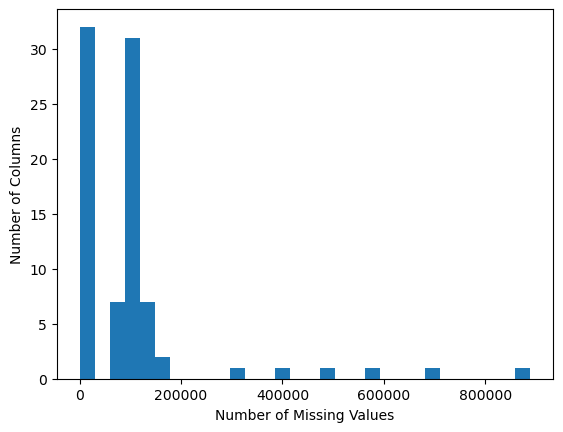

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values, bins=30)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')
plt.show()


In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outliers=missing_values[missing_values>200000]
print("Outliers to drop:", outliers.index)

azdias_cleaned=azdias_cleaned.drop(outliers.index, axis=1, errors='ignore')

Outliers to drop: Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

### Answer:

It appears that the majority of columns exhibit fewer than 200,000 missing values. As a result, I opted to exclude any columns with missing value counts exceeding 200,000. The columns that were eliminated include: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

missing_per_row = azdias_cleaned.isnull().sum(axis=1)

In [17]:
print(missing_per_row.describe(percentiles=[.25, .5, .75, .95]))

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
95%          47.000000
max          49.000000
dtype: float64


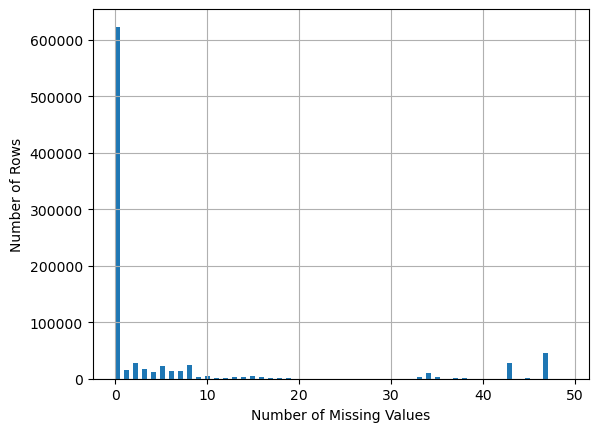

In [21]:
missing_per_row.hist(bins=100)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.show()

The data suggests that the majority of rows exhibit no missing values, as indicated by the 50th percentile (median) being 0. Moreover, in the histogram, a noticeable gap emerges between instances with around 20 and 30 missing column values.

Taking a more heuristic perspective rather than a purely statistical one, let's categorize rows differently based on the number of missing values. We'll classify rows with 25 or fewer missing values as "few missing data" and categorize the remaining rows as "many missing data".

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_few_missing = azdias_cleaned[missing_per_row <= 25]
azdias_many_missing = azdias_cleaned[missing_per_row > 25]


In [24]:
print("azdias_few_md:")
display(azdias_few_missing.head())

azdias_few_md:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [25]:
print("azdias_many_md:")
display(azdias_many_missing.head())

azdias_many_md:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


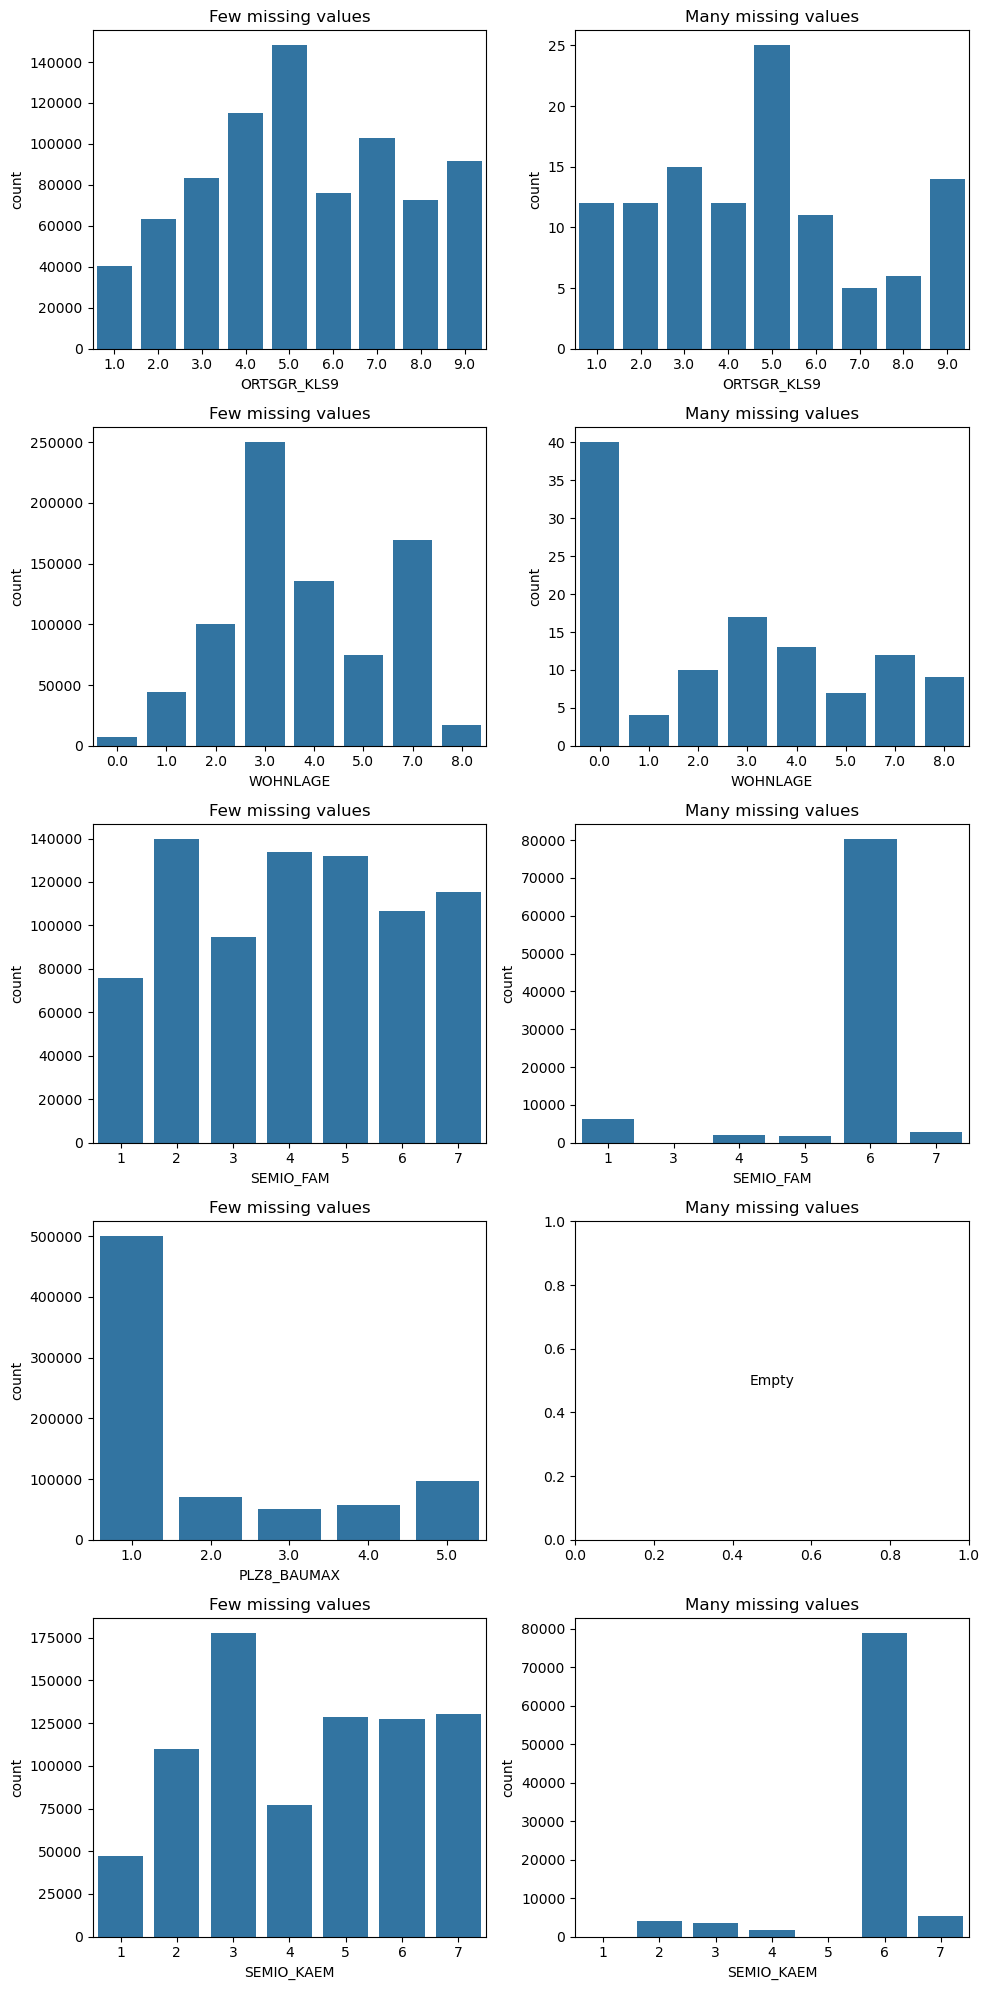

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
random_state=13

# Set a random seed for reproducibility
np.random.seed(random_state)

# Randomly select five columns with few or no missing values
random_cols = np.random.choice(azdias_few_missing.columns, size=5, replace=False)

# Create a subplot grid for visualization
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# Define a function to plot the distribution of values for a column
def plot_column(axes, df, col, dfname, xpos=0):
    color = sns.color_palette()[0]
    
    # If the entire column is empty, display "Empty"
    if df[col].isna().all():
        axes[i, xpos].text(0.5, 0.5, 'Empty', ha='center', va='center')
        axes[i, xpos].set_title(f'{dfname}')
    else:
        # Plot a count plot for the column's values
        sns.countplot(x=col, data=df, ax=axes[i, xpos], color=color,
                      order=sorted(df[col].dropna().unique()))
        axes[i, xpos].set_title(f'{dfname}')
        
# Loop through the randomly selected columns and plot their distributions
for i, col in enumerate(random_cols):
    # Call the plot_column function for the subset with few missing values
    plot_column(axes, azdias_few_missing, col, "Few missing values", xpos=0)
    
    # Call the plot_column function for the subset with many missing values
    plot_column(axes, azdias_many_missing, col, "Many missing values", xpos=1)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Answer
As evident from the random columns displayed above, the distributions of column values in the dataset with few missing values notably differ from those in the dataset with many missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?

feat_info[feat_info['attribute'].isin(azdias_few_missing.columns)]['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: determine which are binary, multi-level, and
# which ones need re-encoding.

# Get all the categorical columns from the feature info that are present in the dataset
cat_cols = feat_info[(feat_info['attribute'].isin(azdias_few_missing.columns)) &
                     (feat_info['type'] == 'categorical')]['attribute']

# Initialize lists to categorize columns
binary_num_cols = []   # Binary categorical columns with numeric values
binary_str_cols = []   # Binary categorical columns with string values
multi_cols = []        # Multi-level categorical columns

# Loop through each categorical column to categorize them
for col in cat_cols:
    vc = azdias_few_missing[col].value_counts()
    
    # Check if it's a binary categorical column with numeric values
    if vc.shape[0] == 2 and isinstance(vc.index[0], (int, float, np.number)):
        binary_num_cols.append(col)

    # Check if it's a binary categorical column with string values
    elif vc.shape[0] == 2 and isinstance(vc.index[0], str):
        binary_str_cols.append(col)
    
    # Check if it's a multi-level categorical column
    elif vc.shape[0] > 2:
        multi_cols.append(col)
        
# Print the results for each category
print("Binary features, numeric:", binary_num_cols)
print("Binary features, string:", binary_str_cols)
print("Multi-level features:", multi_cols)


Binary features, numeric: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
Binary features, string: ['OST_WEST_KZ']
Multi-level features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Create a copy of the subset for re-encoding
azdias_reencoded = azdias_few_missing.copy()

# Loop through binary categorical columns with string values for re-encoding
for col in binary_str_cols:
    
    # Create a dictionary to map unique values to integer encoding {'v1': 0, 'v2': 1}
    value_map = azdias_reencoded[col].value_counts().to_dict()
    for i, key in enumerate(value_map.keys()):
        value_map[key] = i
    
    # Map and store the integer-encoded values in azdias_reencoded
    azdias_reencoded[col] = azdias_reencoded[col].map(value_map)

# Drop multi-level categorical columns from the analysis
azdias_reencoded = azdias_reencoded.drop(multi_cols, axis=1, errors='ignore')

# Display the updated information about the dataset after re-encoding and dropping columns
azdias_reencoded.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Data columns (total 66 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   795160 non-null  float64
 1   ANREDE_KZ              797961 non-null  int64  
 2   FINANZ_MINIMALIST      797961 non-null  int64  
 3   FINANZ_SPARER          797961 non-null  int64  
 4   FINANZ_VORSORGER       797961 non-null  int64  
 5   FINANZ_ANLEGER         797961 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  797961 non-null  int64  
 7   FINANZ_HAUSBAUER       797961 non-null  int64  
 8   GREEN_AVANTGARDE       797961 non-null  int64  
 9   HEALTH_TYP             761281 non-null  float64
 10  LP_LEBENSPHASE_FEIN    747828 non-null  float64
 11  LP_LEBENSPHASE_GROB    750714 non-null  float64
 12  PRAEGENDE_JUGENDJAHRE  769252 non-null  float64
 13  RETOURTYP_BK_S         793248 non-null  float64
 14  SEMIO_SOZ              797961 non-nu

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# The values in PRAEGENDE_JUGENDJAHRE are as follows:
display(azdias_reencoded['PRAEGENDE_JUGENDJAHRE'].value_counts())

# I'm too lazy to manually type the value mappings, so let's just code it

# From Data Dictionary.md
vals = """1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)""".split("\n")

generation_vals = {}
movement_vals = {}

movement_types = []

# Get the values using regex, then set the mapping dictionaries
for val in vals:
    match = re.search(r"(\d+): (\d+)s.*\((\w+)", val)
    num = match.group(1)  # 1
    decade = match.group(2)  # 40
    movement = match.group(3)  # Mainstream
    generation_vals[float(num)] = int(decade)
    if movement.lower() not in movement_types:
        movement_types.append(movement.lower())
    movement_vals[float(num)] = movement_types.index(movement.lower())

print("Mapping for generations:")
display(generation_vals)

print("Mapping for movements:")
display(movement_vals)

# Now create the fields
azdias_mixed1 = azdias_reencoded.copy()
azdias_mixed1['PRAEGENDE_JUGENDJAHRE'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].astype('float')
azdias_mixed1['GENERATION'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(generation_vals)
azdias_mixed1['MOVEMENT'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(movement_vals)

print("Results:")
display(azdias_mixed1[['PRAEGENDE_JUGENDJAHRE', 'GENERATION', 'MOVEMENT']].value_counts())

print("To verify:")
display(vals)

14.0    182968
8.0     141612
10.0     85800
5.0      84687
3.0      53841
15.0     42543
11.0     35751
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

Mapping for generations:


{1.0: 40,
 2.0: 40,
 3.0: 50,
 4.0: 50,
 5.0: 60,
 6.0: 60,
 7.0: 60,
 8.0: 70,
 9.0: 70,
 10.0: 80,
 11.0: 80,
 12.0: 80,
 13.0: 80,
 14.0: 90,
 15.0: 90}

Mapping for movements:


{1.0: 0,
 2.0: 1,
 3.0: 0,
 4.0: 1,
 5.0: 0,
 6.0: 1,
 7.0: 1,
 8.0: 0,
 9.0: 1,
 10.0: 0,
 11.0: 1,
 12.0: 0,
 13.0: 1,
 14.0: 0,
 15.0: 1}

Results:


PRAEGENDE_JUGENDJAHRE  GENERATION  MOVEMENT
14.0                   90.0        0.0         182968
8.0                    70.0        0.0         141612
10.0                   80.0        0.0          85800
5.0                    60.0        0.0          84687
3.0                    50.0        0.0          53841
15.0                   90.0        1.0          42543
11.0                   80.0        1.0          35751
9.0                    70.0        1.0          33570
6.0                    60.0        1.0          25652
12.0                   80.0        0.0          24446
1.0                    40.0        0.0          20678
4.0                    50.0        1.0          20451
2.0                    40.0        1.0           7479
13.0                   80.0        1.0           5764
7.0                    60.0        1.0           4010
dtype: int64

To verify:


['1: 40s - war years (Mainstream, E+W)',
 '2: 40s - reconstruction years (Avantgarde, E+W)',
 '3: 50s - economic miracle (Mainstream, E+W)',
 '4: 50s - milk bar / Individualisation (Avantgarde, E+W)',
 '5: 60s - economic miracle (Mainstream, E+W)',
 '6: 60s - generation 68 / student protestors (Avantgarde, W)',
 '7: 60s - opponents to the building of the Wall (Avantgarde, E)',
 '8: 70s - family orientation (Mainstream, E+W)',
 '9: 70s - peace movement (Avantgarde, E+W)',
 '10: 80s - Generation Golf (Mainstream, W)',
 '11: 80s - ecological awareness (Avantgarde, W)',
 '12: 80s - FDJ / communist party youth organisation (Mainstream, E)',
 '13: 80s - Swords into ploughshares (Avantgarde, E)',
 '14: 90s - digital media kids (Mainstream, E+W)',
 '15: 90s - ecological awareness (Avantgarde, E+W)']

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

    
# The values in CAMEO_INTL_2015 are as follows:
display(azdias_mixed1['CAMEO_INTL_2015'].value_counts())

# From Data Dictionary.md
vals = """11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement""".split("\n")

wealth_vals = {}
life_stage_vals = {}

# Get the values using regex, then set the mapping dictionaries
for val in vals:
    match = re.search(r"(\d)(\d): (.*) - (.*)", val)
    wealth = match.group(1)
    life_stage = match.group(2)
    num = wealth + life_stage
    
    wealth_vals[float(num)] = int(wealth)
    life_stage_vals[float(num)] = int(life_stage)

print("Mapping for wealth:")
display(wealth_vals)

print("Mapping for life_stage:")
display(life_stage_vals)

# Now create the fields
azdias_mixed2 = azdias_mixed1.copy()
azdias_mixed2['CAMEO_INTL_2015'] = azdias_mixed2['CAMEO_INTL_2015'].astype('float')
azdias_mixed2['WEALTH'] = azdias_mixed2['CAMEO_INTL_2015'].map(wealth_vals)
azdias_mixed2['LIFE_STAGE'] = azdias_mixed2['CAMEO_INTL_2015'].map(life_stage_vals)

print("Results:")
display(azdias_mixed2[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].value_counts())

51    133693
41     92336
24     91152
14     62882
43     56672
54     45390
25     39624
22     33152
23     26746
13     26334
45     26132
55     23954
52     20542
31     19020
34     18524
15     16974
44     14820
12     13248
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

Mapping for wealth:


{11.0: 1,
 12.0: 1,
 13.0: 1,
 14.0: 1,
 15.0: 1,
 21.0: 2,
 22.0: 2,
 23.0: 2,
 24.0: 2,
 25.0: 2,
 31.0: 3,
 32.0: 3,
 33.0: 3,
 34.0: 3,
 35.0: 3,
 41.0: 4,
 42.0: 4,
 43.0: 4,
 44.0: 4,
 45.0: 4,
 51.0: 5,
 52.0: 5,
 53.0: 5,
 54.0: 5,
 55.0: 5}

Mapping for life_stage:


{11.0: 1,
 12.0: 2,
 13.0: 3,
 14.0: 4,
 15.0: 5,
 21.0: 1,
 22.0: 2,
 23.0: 3,
 24.0: 4,
 25.0: 5,
 31.0: 1,
 32.0: 2,
 33.0: 3,
 34.0: 4,
 35.0: 5,
 41.0: 1,
 42.0: 2,
 43.0: 3,
 44.0: 4,
 45.0: 5,
 51.0: 1,
 52.0: 2,
 53.0: 3,
 54.0: 4,
 55.0: 5}

Results:


CAMEO_INTL_2015  WEALTH  LIFE_STAGE
51.0             5.0     1.0           133693
41.0             4.0     1.0            92336
24.0             2.0     4.0            91152
14.0             1.0     4.0            62882
43.0             4.0     3.0            56672
54.0             5.0     4.0            45390
25.0             2.0     5.0            39624
22.0             2.0     2.0            33152
23.0             2.0     3.0            26746
13.0             1.0     3.0            26334
45.0             4.0     5.0            26132
55.0             5.0     5.0            23954
52.0             5.0     2.0            20542
31.0             3.0     1.0            19020
34.0             3.0     4.0            18524
15.0             1.0     5.0            16974
44.0             4.0     4.0            14820
12.0             1.0     2.0            13248
35.0             3.0     5.0            10356
32.0             3.0     2.0            10354
33.0             3.0     3.0             993

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Answer
- MOVEMENT: Binary (0 or 1).
- Binary encoding is used because there are only two values, allowing efficient representation.
- GENERATION: Interval (10, 20, etc.).

Interval encoding is chosen because there is a natural order to the decades (40s, 50s, etc.) and their distances matter.
WEALTH, LIFE_STAGE: Ordinal.

Ordinal encoding is preferred due to the inherent ordering of values (e.g., Wealthy Households < Prosperous Households < etc.), even though the distances between categories are not relevant.
The selection of encoding methods is based on the characteristics and relationships of the variables to best capture the information they convey efficiently.






#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [43]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
number=0
# Remove mixed columns
mixed_cols = feat_info[feat_info['type'] == 'mixed']['attribute']
azdias_cleaned1 = azdias_mixed2.drop(mixed_cols, axis=1, errors='ignore')
azdias_cleaned1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   795160 non-null  float64
 1   ANREDE_KZ              797961 non-null  int64  
 2   FINANZ_MINIMALIST      797961 non-null  int64  
 3   FINANZ_SPARER          797961 non-null  int64  
 4   FINANZ_VORSORGER       797961 non-null  int64  
 5   FINANZ_ANLEGER         797961 non-null  int64  
 6   FINANZ_UNAUFFAELLIGER  797961 non-null  int64  
 7   FINANZ_HAUSBAUER       797961 non-null  int64  
 8   GREEN_AVANTGARDE       797961 non-null  int64  
 9   HEALTH_TYP             761281 non-null  float64
 10  RETOURTYP_BK_S         793248 non-null  float64
 11  SEMIO_SOZ              797961 non-null  int64  
 12  SEMIO_FAM              797961 non-null  int64  
 13  SEMIO_REL              797961 non-null  int64  
 14  SEMIO_MAT              797961 non-nu

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:
 def clean_data(df, cols_to_remove=[]):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Identify missing or unknown data values and convert them to NaNs.
    azdias_cleaned = df.copy()
    def is_integer(s):
        try:
            int(s)
            return True
        except ValueError:
            return False
    def parse_string(s):
        # Remove brackets and split by comma
        parts = s.strip("[]").split(",")
        # Convert numeric strings to int, leave others as string
        return [int(x) if is_integer(x) else x.strip('""') for x in parts]

    for fi in tqdm(feat_info.itertuples(), total=feat_info.shape[0]):
        mu = parse_string(fi.missing_or_unknown)
        azdias_cleaned.loc[azdias_cleaned[fi.attribute].isin(mu), fi.attribute] = np.nan
    
    # remove selected columns and rows, ...
    azdias_cleaned=azdias_cleaned.drop(cols_to_remove, axis=1, errors='ignore')
    
    missing_per_row = azdias_cleaned.isnull().sum(axis=1)
    azdias_few_missing = azdias_cleaned[missing_per_row <= 25]
    azdias_many_missing = azdias_cleaned[missing_per_row > 25]

    # select, re-encode, and engineer column values.
    azdias_reencoded = azdias_few_missing
    for col in binary_str_cols:

        # Get a dict object to map {'v1': 0, 'v2': 1}
        value_map = azdias_reencoded[col].value_counts().to_dict()
        for i, key in enumerate(value_map.keys()):
            value_map[key] = i

        # Map and store to azdias_reencoded
        azdias_reencoded[col] = azdias_reencoded[col].map(value_map)

    # Drop multi-level variables
    azdias_reencoded=azdias_reencoded.drop(multi_cols, axis=1, errors='ignore')

    # From Data Dictionary.md
    vals = """1: 40s - war years (Mainstream, E+W)
    2: 40s - reconstruction years (Avantgarde, E+W)
    3: 50s - economic miracle (Mainstream, E+W)
    4: 50s - milk bar / Individualisation (Avantgarde, E+W)
    5: 60s - economic miracle (Mainstream, E+W)
    6: 60s - generation 68 / student protestors (Avantgarde, W)
    7: 60s - opponents to the building of the Wall (Avantgarde, E)
    8: 70s - family orientation (Mainstream, E+W)
    9: 70s - peace movement (Avantgarde, E+W)
    10: 80s - Generation Golf (Mainstream, W)
    11: 80s - ecological awareness (Avantgarde, W)
    12: 80s - FDJ / communist party youth organisation (Mainstream, E)
    13: 80s - Swords into ploughshares (Avantgarde, E)
    14: 90s - digital media kids (Mainstream, E+W)
    15: 90s - ecological awareness (Avantgarde, E+W)""".split("\n")

    generation_vals = {}
    movement_vals = {}

    movement_types = []

    # Get the values using regex, then set the mapping dictionaries
    for val in vals:
        match = re.search(r"(\d+): (\d+)s.*\((\w+)", val)
        num = match.group(1)  # 1
        decade = match.group(2)  # 40
        movement = match.group(3)  # Mainstream
        generation_vals[float(num)] = int(decade)
        if movement.lower() not in movement_types:
            movement_types.append(movement.lower())
        movement_vals[float(num)] = movement_types.index(movement.lower())

    # Now create the fields
    azdias_mixed1 = azdias_reencoded
    azdias_mixed1['GENERATION'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(generation_vals)
    azdias_mixed1['MOVEMENT'] = azdias_mixed1['PRAEGENDE_JUGENDJAHRE'].map(movement_vals)
    
    # From Data Dictionary.md
    vals = """11: Wealthy Households - Pre-Family Couples & Singles
    12: Wealthy Households - Young Couples With Children
    13: Wealthy Households - Families With School Age Children
    14: Wealthy Households - Older Families & Mature Couples
    15: Wealthy Households - Elders In Retirement
    21: Prosperous Households - Pre-Family Couples & Singles
    22: Prosperous Households - Young Couples With Children
    23: Prosperous Households - Families With School Age Children
    24: Prosperous Households - Older Families & Mature Couples
    25: Prosperous Households - Elders In Retirement
    31: Comfortable Households - Pre-Family Couples & Singles
    32: Comfortable Households - Young Couples With Children
    33: Comfortable Households - Families With School Age Children
    34: Comfortable Households - Older Families & Mature Couples
    35: Comfortable Households - Elders In Retirement
    41: Less Affluent Households - Pre-Family Couples & Singles
    42: Less Affluent Households - Young Couples With Children
    43: Less Affluent Households - Families With School Age Children
    44: Less Affluent Households - Older Families & Mature Couples
    45: Less Affluent Households - Elders In Retirement
    51: Poorer Households - Pre-Family Couples & Singles
    52: Poorer Households - Young Couples With Children
    53: Poorer Households - Families With School Age Children
    54: Poorer Households - Older Families & Mature Couples
    55: Poorer Households - Elders In Retirement""".split("\n")

    wealth_vals = {}
    life_stage_vals = {}

    # Get the values using regex, then set the mapping dictionaries
    for val in vals:
        match = re.search(r"(\d)(\d): (.*) - (.*)", val)
        wealth = match.group(1)
        life_stage = match.group(2)
        num = wealth + life_stage

        wealth_vals[int(num)] = int(wealth)
        life_stage_vals[int(num)] = int(life_stage)

    # Now create the fields
    azdias_mixed2 = azdias_mixed1
    azdias_mixed2['CAMEO_INTL_2015'] = azdias_mixed2['CAMEO_INTL_2015'].astype(float)
    azdias_mixed2['WEALTH'] = azdias_mixed2['CAMEO_INTL_2015'].map(wealth_vals)
    azdias_mixed2['LIFE_STAGE'] = azdias_mixed2['CAMEO_INTL_2015'].map(life_stage_vals)

    # Return the cleaned dataframe.
    mixed_cols = feat_info[feat_info['type'] == 'mixed']['attribute']
    azdias_cleaned1 = azdias_mixed2.drop(mixed_cols, axis=1, errors='ignore')
    return azdias_cleaned1

# All the code above can be applied to a Dataframe as follows.
# Note that `cols_to_remove` needs to be passed manually since the selection was made by which
# columns had < 200,000 rows and that may not applicable in the customers dataset.
df_cleaned = clean_data(azdias, cols_to_remove=outliers.index)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:07<00:00, 11.48it/s]
C:\Users\aljoh\AppData\Local\Temp\ipykernel_2684\201743287.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_reencoded[col] = azdias_reencoded[col].map(value_map)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [56]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
num_missing = df_cleaned.isnull().any(axis=1).sum()
num_total = df_cleaned.shape[0]
perc = round(num_missing / num_total * 100, 2)
print(f"We have {num_missing} rows of missing data out of {num_total} rows ({perc}%)")
df_cleaned_no_md = df_cleaned.dropna()
df_cleaned_no_md.info()


We have 174750 rows of missing data out of 797961 rows (21.9%)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 623211 entries, 1 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   623211 non-null  float64
 1   ANREDE_KZ              623211 non-null  float64
 2   FINANZ_MINIMALIST      623211 non-null  float64
 3   FINANZ_SPARER          623211 non-null  float64
 4   FINANZ_VORSORGER       623211 non-null  float64
 5   FINANZ_ANLEGER         623211 non-null  float64
 6   FINANZ_UNAUFFAELLIGER  623211 non-null  float64
 7   FINANZ_HAUSBAUER       623211 non-null  float64
 8   GREEN_AVANTGARDE       623211 non-null  float64
 9   HEALTH_TYP             623211 non-null  float64
 10  RETOURTYP_BK_S         623211 non-null  float64
 11  SEMIO_SOZ              623211 non-null  float64
 12  SEMIO_FAM              623211 non-null  float64
 13  SEMIO_REL              623

In [58]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()


In [59]:

# Fit the scaler and transform the cleaned dataset
df_cleaned_no_md_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned_no_md),
                                       columns=df_cleaned_no_md.columns)


In [61]:
df_cleaned_no_md_scaled.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,-1.665693,0.388390,-0.041041,0.053096,-0.421293,-1.704580,-1.090399,-1.407641,-0.593940,1.265682,-0.288620,1.285085,-0.134390,1.491936,1.256809,10.801657,0.937389,0.170632,-0.060732,0.978312,-0.688383,0.548077,0.166229,-0.129568,-1.283851,-0.344822,-0.519208,-1.065424,-1.024112,-0.620111,2.680144,-1.631654,0.867558,-0.601198,1.728772,-0.797503,-0.744663,-1.384496,0.164130,-0.804366,1.056290,-0.234263,0.182484,0.374154,0.384671,1.441603,0.583438,-0.201175,-0.171843,0.656464,1.164455,-0.553672,1.147884,-1.251111
1,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,-0.290658,-0.123869,-1.602198,-0.480080,-0.421293,-0.143569,-0.150230,0.781263,-0.593940,0.084594,1.414522,1.285085,1.427580,-0.588811,-0.408540,-0.092578,-1.066793,-0.719121,-0.060732,-0.351529,-0.688383,0.548077,0.101261,-0.129568,1.331138,-0.344822,-0.519208,-0.358098,1.380706,0.359116,-0.473109,-0.113434,-0.952492,-0.013343,-0.239106,0.298400,-0.744663,0.023883,-0.480529,-1.350568,0.301159,0.788322,0.182484,-0.641995,-0.981973,0.400951,0.583438,-0.201175,-0.171843,-0.823841,1.164455,1.806125,-0.909992,0.749820
2,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,1.084378,0.900649,-0.041041,0.053096,-0.931524,1.417443,-0.150230,-0.313189,0.920047,-1.096495,-0.856334,-1.390473,-1.175703,-0.068625,-0.963657,-0.092578,0.937389,1.950138,-0.060732,0.313391,-1.263744,0.548077,-0.353510,-0.129568,0.677391,-0.344822,-0.519208,-0.358098,2.182312,0.359116,-0.473109,-0.113434,-0.952492,0.574513,-1.715015,1.394302,0.277472,0.023883,1.453447,0.288038,-0.532191,-0.234263,1.272515,0.374154,0.384671,-0.639701,-0.314765,0.809745,0.263750,1.396616,-0.213395,-0.553672,0.461926,0.082843
3,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,-0.290658,-1.148386,-0.041041,1.652625,0.088938,-1.184243,-1.090399,-1.407641,0.415384,1.856227,-0.288620,-0.320250,-0.134390,1.491936,1.256809,-0.092578,0.937389,-0.719121,-0.060732,0.313391,1.037699,0.548077,-0.223576,-0.129568,1.331138,-0.344822,-0.519208,0.349228,0.579100,-0.620111,-0.473109,0.645675,0.867558,-1.189053,1.236802,0.298400,1.299607,0.728073,-1.125188,0.288038,2.070149,-0.234263,0.182484,-0.641995,0.384671,1.441603,1.481641,-1.212095,-1.043031,-0.083688,-1.591245,-0.553672,1.147884,0.749820
4,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,0.396860,-1.148386,0.479345,0.586272,1.619630,-1.184243,0.789940,0.234037,0.415384,1.856227,1.414522,-0.320250,1.427580,1.491936,1.811925,-0.092578,-1.066793,-0.719121,-0.060732,0.978312,-0.688383,0.548077,-0.288543,-0.129568,1.331138,-0.344822,-0.519208,1.056555,0.579100,-0.620111,-0.473109,-0.113434,0.867558,-0.013343,-0.731076,1.394302,0.277472,1.432263,-0.480529,0.288038,0.767475,0.788322,0.182484,-0.641995,-0.981973,1.441603,1.481641,0.809745,0.263750,-0.083688,0.475530,-0.553672,-0.909992,-0.584134


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Answer
Out of a total of 797,961 rows, a substantial portion of 174,750 rows had missing data, accounting for approximately 21.9% of the dataset.

After careful consideration, I opted to exclude all rows containing NaN values. However, to retain the option of potentially reintroducing these missing-data rows at a later stage, I stored the cleaned dataset in a new variable named df_cleaned_no_md. This approach allows for flexibility in case I decide to reintegrate these rows into the dataset, depending on the quality of the analysis outcomes.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
# Apply PCA to the data.
pca = PCA()
pca_transformed_data = pca.fit_transform(df_cleaned_no_md_scaled)


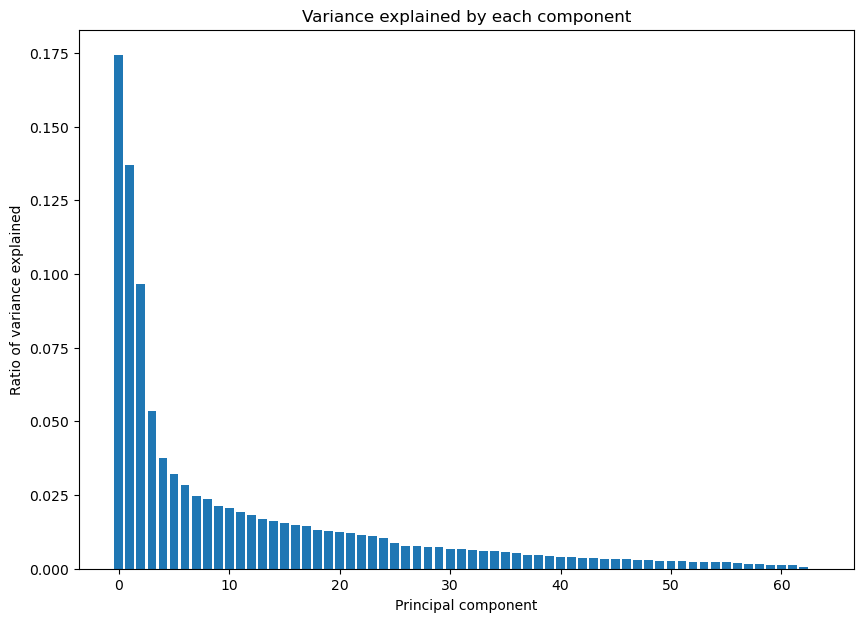

In [63]:
# Investigate the variance accounted for by each principal component.


explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 7))
plt.bar(range(len(explained_variance)), explained_variance)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

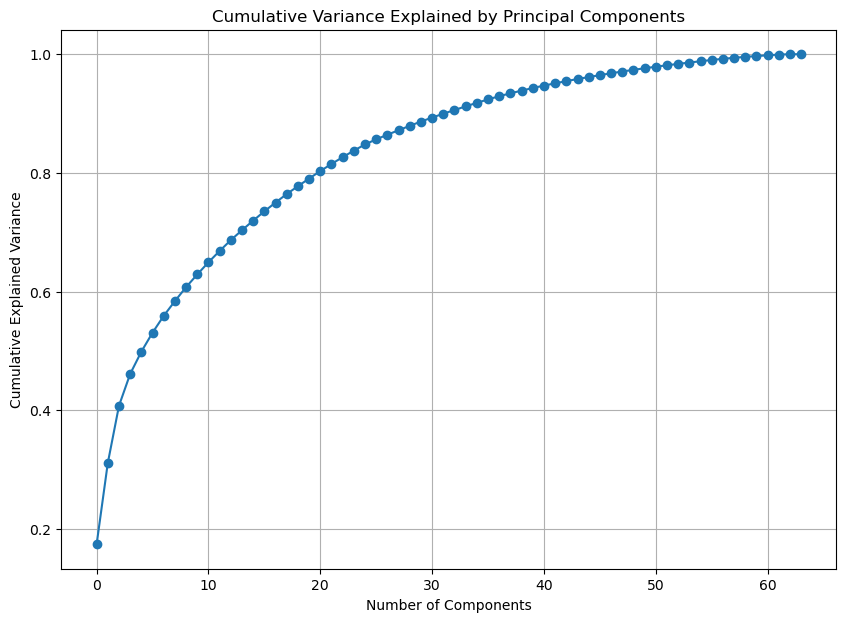

In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 7))
plt.plot(range(len(cumulative_variance)), cumulative_variance, 'o-')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


In [65]:

variances = [0.95, 0.9, 0.85, 0.8]
for v in variances:
    n_components = np.where(cumulative_variance > v)[0][0] + 1
    print(f'Number of components that explain {round(v*100)}% variance: {n_components}')

Number of components that explain 95% variance: 42
Number of components that explain 90% variance: 33
Number of components that explain 85% variance: 26
Number of components that explain 80% variance: 21


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Answer
The smoothness of the elbow in the explained variance plot indicates that solely relying on it might not be sufficient to determine the optimal number of components. The choice of components should also align with the downstream tasks. If the subsequent steps involve noise-sensitive models or those sensitive to irrelevant features (such as certain neural networks), opting for a higher number of components, say 42, could be favorable to retain as much information as possible. However, if computational efficiency and dimensionality reduction are the main concerns, a lower number of components, like 21 or 26, might be preferred.

Considering the anticipation of deep learning applications (although not covered in this project), I've decided to choose 42 components. Later, I could compare the prediction outcomes with those obtained using 21 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

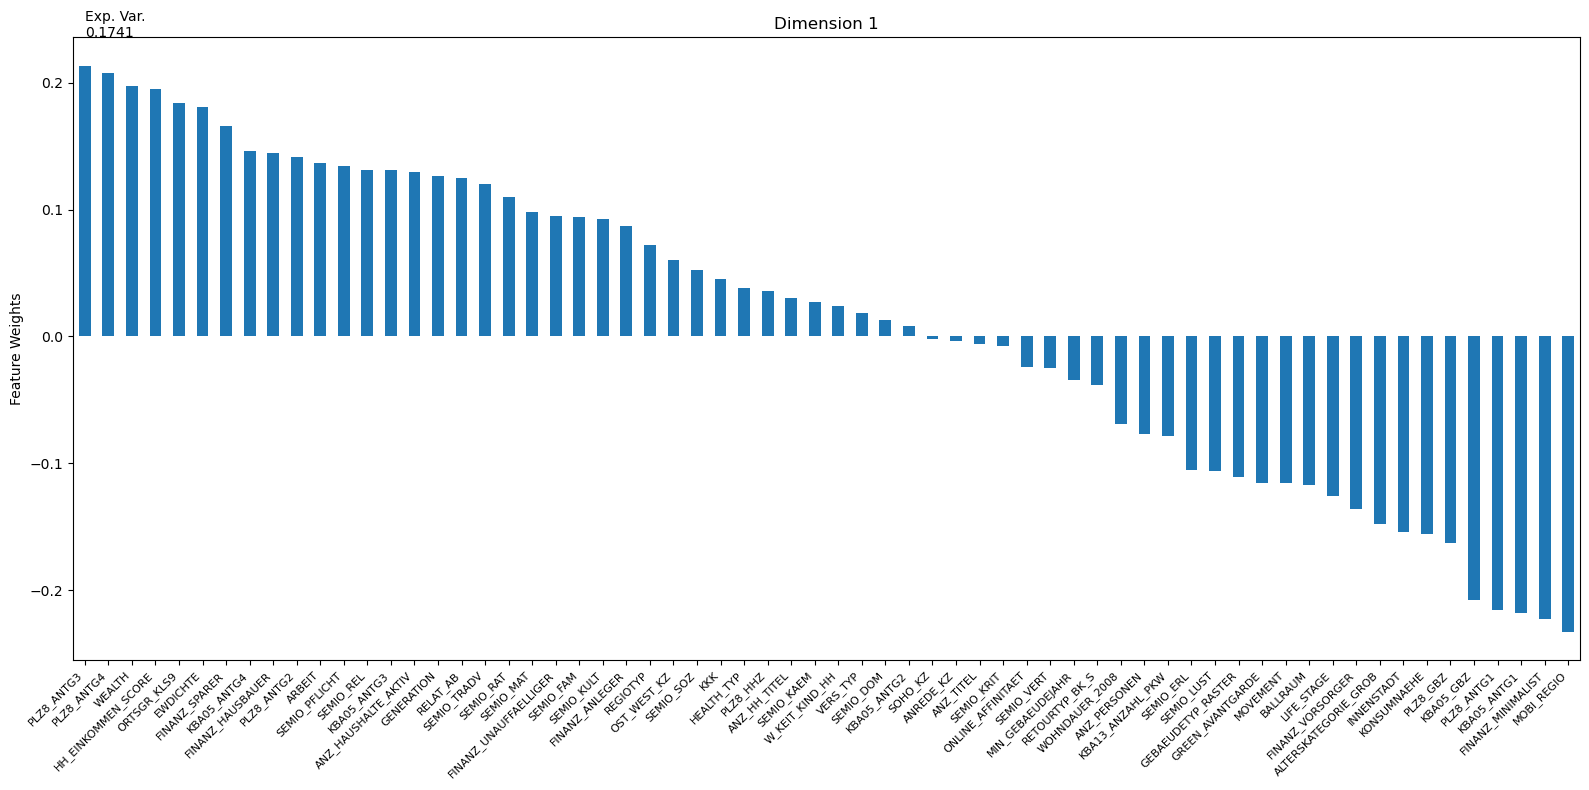

PLZ8_ANTG3               0.2137
PLZ8_ANTG4               0.2076
WEALTH                   0.1972
HH_EINKOMMEN_SCORE       0.1951
ORTSGR_KLS9              0.1842
EWDICHTE                 0.1812
Explained Variance       0.1741
FINANZ_SPARER            0.1658
KBA05_ANTG4              0.1463
FINANZ_HAUSBAUER         0.1449
PLZ8_ANTG2               0.1416
ARBEIT                   0.1372
SEMIO_PFLICHT            0.1342
SEMIO_REL                0.1316
KBA05_ANTG3              0.1315
ANZ_HAUSHALTE_AKTIV      0.1301
GENERATION               0.1267
RELAT_AB                  0.125
SEMIO_TRADV              0.1203
SEMIO_RAT                0.1102
SEMIO_MAT                0.0978
FINANZ_UNAUFFAELLIGER    0.0947
SEMIO_FAM                0.0946
SEMIO_KULT               0.0928
FINANZ_ANLEGER           0.0873
REGIOTYP                 0.0723
OST_WEST_KZ              0.0601
SEMIO_SOZ                0.0527
KKK                      0.0457
HEALTH_TYP               0.0386
PLZ8_HHZ                 0.0356
ANZ_HH_T

In [66]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(features_list, pca, component_indices=None, n_weights=None):
    '''
    Generates a bar plot of feature weights for each principal component and returns a DataFrame
    with these weights and the explained variance ratios. 
    
    The principal components can be selectively visualized by specifying their indices. The feature
    weights in each component can also be selectively visualized by specifying the number of largest
    and smallest weights to be shown. 

    Parameters:
    - features_list: List of feature names corresponding to the weights in the principal components.
    - pca: Fitted PCA object from sklearn.decomposition.PCA.
    - component_indices (optional): List of indices of principal components to visualize and include in output DataFrame.
        If not specified, all components are included.
    - n_weights (optional): List of two elements representing the number of largest and smallest weights to visualize
        and include in output DataFrame. If not specified, all weights are included.

    Returns:
    - A DataFrame containing the explained variance ratios and feature weights of the specified principal components.
    The feature weights are sorted by their absolute values within each component. 
    The DataFrame is sorted by the explained variance ratios in descending order.
    
    Also displays a bar plot of the feature weights for each specified principal component, sorted by their absolute values.
    The explained variance ratio for each component is displayed on the plot. 
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = features_list)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Subset the components and explained variance ratios if component_indices is specified
    if component_indices is not None:
        dimensions = [dimensions[i] for i in component_indices]
        components = components.loc[dimensions]
        variance_ratios = variance_ratios.loc[dimensions]

    # Subset the components to the n largest and smallest weights
    components_subset = pd.DataFrame(index=components.index, columns=features_list)
    for dim in dimensions:
        sorted_weights = components.loc[dim].sort_values(ascending=False)
        if n_weights:
            largest_n = n_weights[0] if n_weights[0] else None
            smallest_n = n_weights[1] if n_weights[1] else None
            largest_weights = sorted_weights.head(largest_n) if largest_n else sorted_weights
            smallest_weights = sorted_weights.tail(smallest_n) if smallest_n else sorted_weights
            components_subset.loc[dim] = pd.concat([largest_weights, smallest_weights])
        else:
            components_subset.loc[dim] = sorted_weights

    # Determine number of subplots needed
    n_plots = len(component_indices) if component_indices else len(pca.components_)
    n_cols = 1  # set number of columns for subplots
    n_rows = int(np.ceil(n_plots / n_cols))

    # Create a bar plot visualization
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8*n_rows))

    # I can't decide to use two cols or one row, so I added this.
    if n_cols == 1:  
        axs = np.expand_dims(axs, axis=-1)
    
    axs = axs.flatten()

    # Plot the feature weights as a function of the components
    for idx, ax in enumerate(axs):
        if idx < len(dimensions):
            # Sort by weight within each component
            components_subset.loc[dimensions[idx]].sort_values(ascending=False).plot(kind='bar', ax=ax)
            ax.set_title(dimensions[idx])
            ax.set_ylabel("Feature Weights")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

            # Display the explained variance ratios
            ev = variance_ratios.loc[dimensions[idx], 'Explained Variance']
            ax.text(0, ax.get_ylim()[1], "Exp. Var.\n%.4f"%(ev))
        else:
            fig.delaxes(ax)

    # Adjust overall plot
    fig.tight_layout()
    plt.show()

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components_subset], axis = 1)

df_pca_summary1 = pca_results(df_cleaned_no_md_scaled.columns, pca, component_indices=[0], n_weights=None)
display(df_pca_summary1.iloc[0].sort_values(ascending=False))


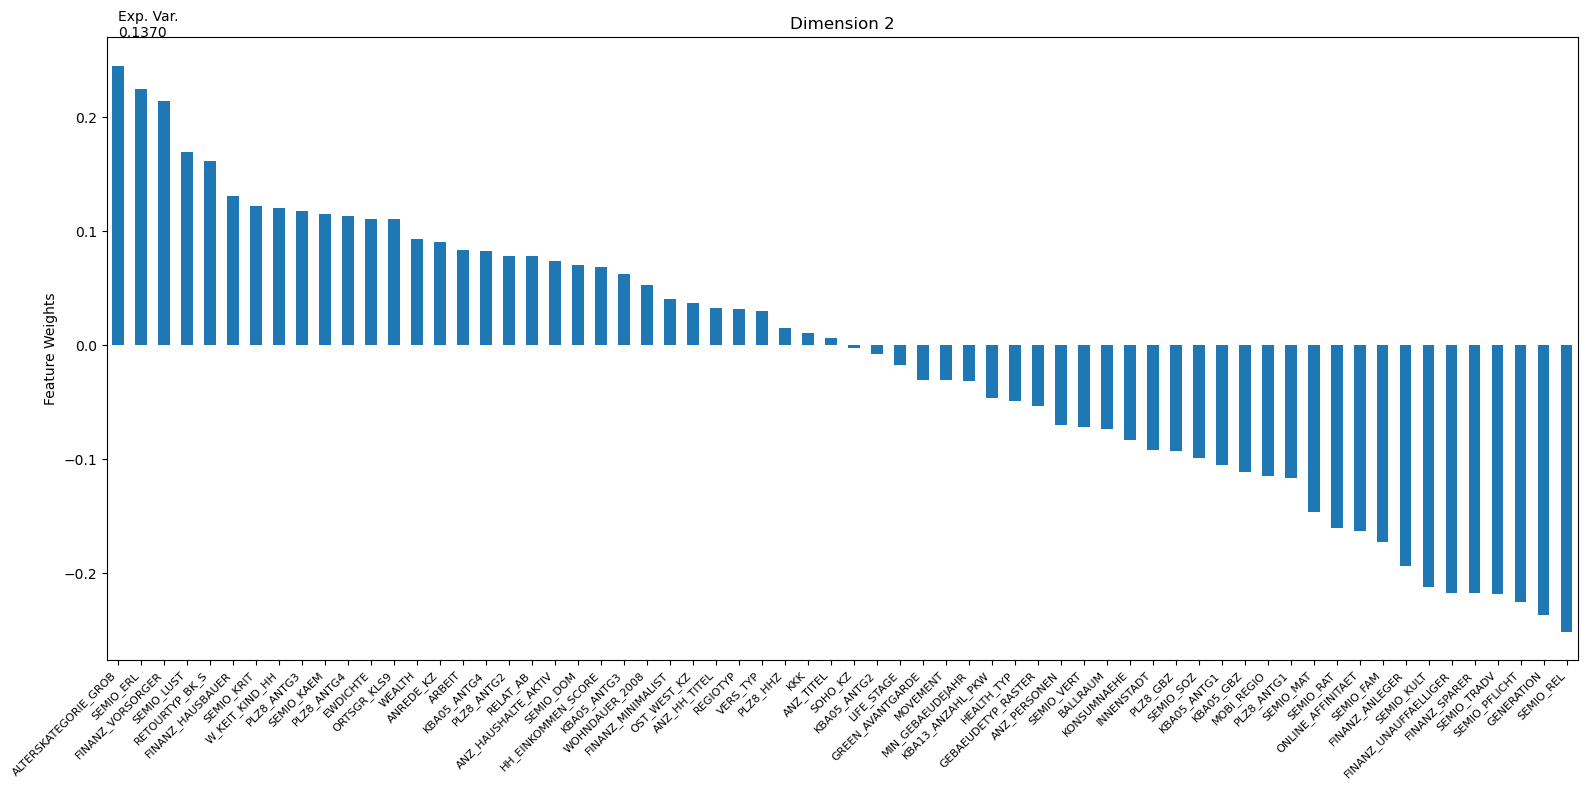

ALTERSKATEGORIE_GROB     0.2452
SEMIO_ERL                0.2243
FINANZ_VORSORGER         0.2138
SEMIO_LUST               0.1691
RETOURTYP_BK_S           0.1611
Explained Variance        0.137
FINANZ_HAUSBAUER         0.1309
SEMIO_KRIT               0.1221
W_KEIT_KIND_HH           0.1199
PLZ8_ANTG3               0.1178
SEMIO_KAEM               0.1154
PLZ8_ANTG4               0.1129
EWDICHTE                 0.1108
ORTSGR_KLS9              0.1106
WEALTH                   0.0927
ANREDE_KZ                0.0902
ARBEIT                   0.0832
KBA05_ANTG4              0.0828
PLZ8_ANTG2                0.078
RELAT_AB                 0.0778
ANZ_HAUSHALTE_AKTIV      0.0734
SEMIO_DOM                0.0706
HH_EINKOMMEN_SCORE       0.0685
KBA05_ANTG3              0.0621
WOHNDAUER_2008           0.0525
FINANZ_MINIMALIST        0.0408
OST_WEST_KZ              0.0373
ANZ_HH_TITEL             0.0329
REGIOTYP                 0.0313
VERS_TYP                 0.0299
PLZ8_HHZ                 0.0149
KKK     

In [67]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_pca_summary2 = pca_results(df_cleaned_no_md_scaled.columns, pca, component_indices=[1], n_weights=None)
display(df_pca_summary2.iloc[0].sort_values(ascending=False))

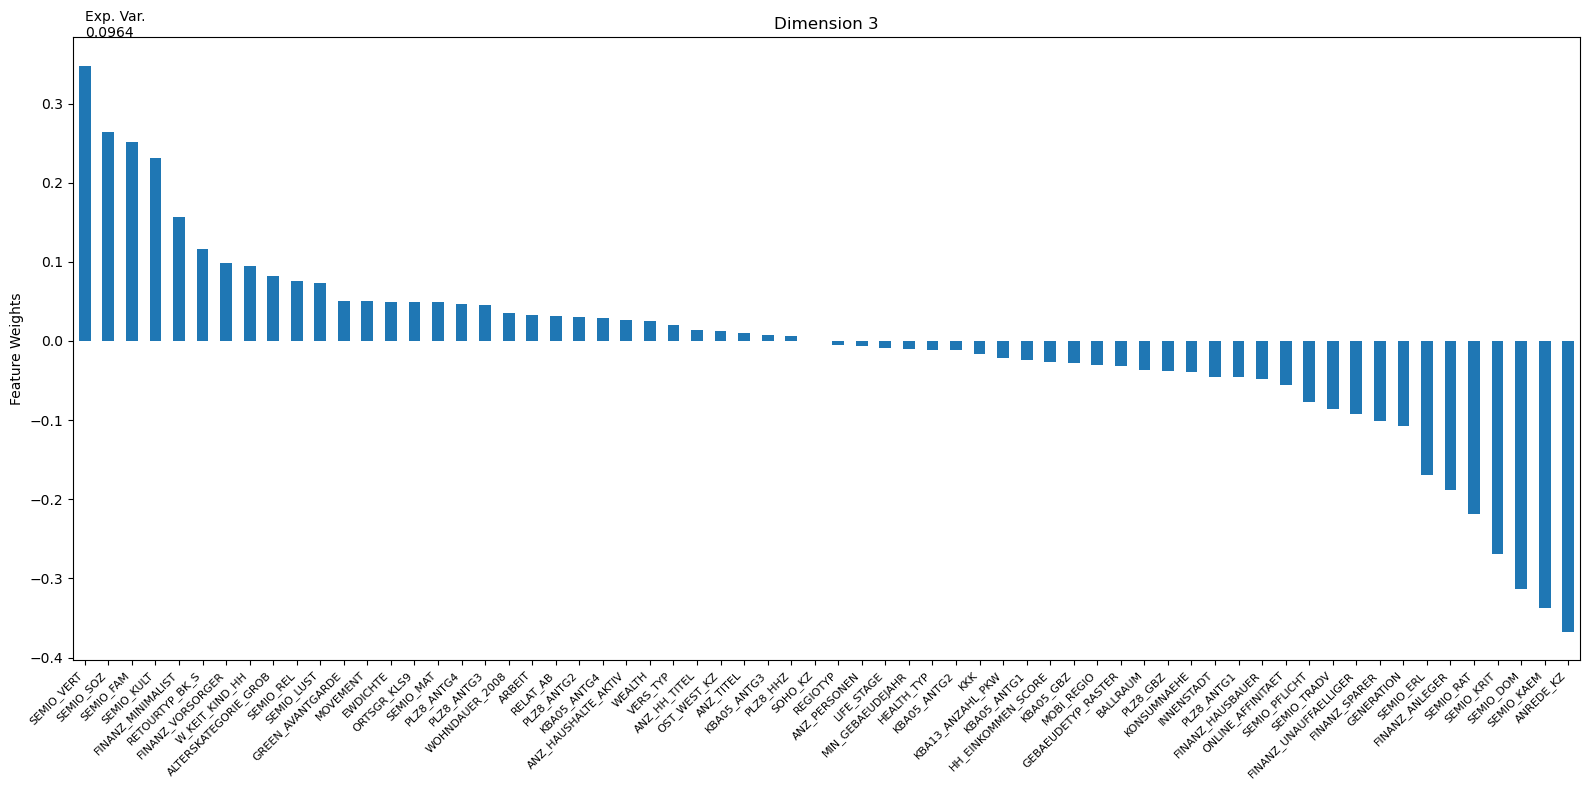

SEMIO_VERT                0.348
SEMIO_SOZ                0.2636
SEMIO_FAM                0.2514
SEMIO_KULT               0.2315
FINANZ_MINIMALIST        0.1567
RETOURTYP_BK_S            0.116
FINANZ_VORSORGER         0.0982
Explained Variance       0.0964
W_KEIT_KIND_HH           0.0948
ALTERSKATEGORIE_GROB     0.0824
SEMIO_REL                0.0764
SEMIO_LUST               0.0733
MOVEMENT                 0.0509
GREEN_AVANTGARDE         0.0509
EWDICHTE                 0.0491
ORTSGR_KLS9              0.0488
SEMIO_MAT                0.0488
PLZ8_ANTG4               0.0464
PLZ8_ANTG3               0.0458
WOHNDAUER_2008           0.0349
ARBEIT                    0.033
RELAT_AB                 0.0314
PLZ8_ANTG2               0.0303
KBA05_ANTG4              0.0293
ANZ_HAUSHALTE_AKTIV      0.0268
WEALTH                   0.0249
VERS_TYP                 0.0208
ANZ_HH_TITEL             0.0145
OST_WEST_KZ              0.0124
ANZ_TITEL                0.0104
KBA05_ANTG3              0.0071
PLZ8_HHZ

In [68]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df_pca_summary3 = pca_results(df_cleaned_no_md_scaled.columns, pca, component_indices=[2], n_weights=None)
display(df_pca_summary3.iloc[0].sort_values(ascending=False))

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### Answer

As evident from the provided analysis, the principal component with the highest explanatory power (17.41% variance) displays intriguing patterns among its top and bottom 5 features:

Top 5 Features:

- PLZ8_ANTG3: 0.2137
- PLZ8_ANTG4: 0.2076
- WEALTH: 0.1972
- HH_EINKOMMEN_SCORE: 0.1951
- ORTSGR_KLS9: 0.1842

Bottom 5 Features:

- KBA05_GBZ: -0.2081
- PLZ8_ANTG1: -0.2154
- KBA05_ANTG1: -0.2184
- FINANZ_MINIMALIST: -0.2225
- MOBI_REGIO: -0.2331

This primary component appears to group the population based on characteristics related to substantial family houses (6-10 family homes for PLZ8_ANTG3 and 10+ family homes for PLZ8_ANTG4). Subsequently, it aligns with indicators of wealth (WEALTH), income (HH_EINKOMMEN_SCORE), and dwelling type (ORTSGR_KLS9). Conversely, the lower scores associate with aspects tied to financial minimalism (FINANZ_MINIMALIST), housing (KBA05_GBZ), and mobility (MOBI_REGIO). The component is seemingly linked to financial well-being.

More specifically, regions featuring a higher share of 6-10 and 10+ family homes appear to correlate with lower household wealth (high WEALTH, as previously observed). These regions also show strong correlations with heightened mobility patterns (low MOBI_REGIO) and minimal financial interest (FINANZ_MINIMALIST).

Another component of interest is the third component, defined by these weights:

Top 5 Features:

- SEMIO_VERT: 0.348
- SEMIO_SOZ: 0.2636
- SEMIO_FAM: 0.2514
- SEMIO_KULT: 0.2315
- FINANZ_MINIMALIST: 0.1567

Bottom 5 Features:

- SEMIO_RAT: -0.2191
- SEMIO_KRIT: -0.269
- SEMIO_DOM: -0.3127
- SEMIO_KAEM: -0.3371
- ANREDE_KZ: -0.3676

This component appears to categorize the population based on personality traits. Positive correlations are observed with dreamfulness (SEMIO_VERT), social-mindedness (SEMIO_SOZ), family orientation (SEMIO_FAM), and cultural interest (SEMIO_KULT). Conversely, negative correlations exist with traits such as being rational (SEMIO_RAT), critical-mindedness (SEMIO_KRIT), dominance (SEMIO_DOM), and combativeness (SEMIO_KAEM). Furthermore, gender differences are indicated, with women tending to exhibit traits like dreamfulness, social-mindedness, family orientation, and cultural interest, while men lean towards combative attitudes, dominance, and critical-mindedness, aligning somewhat with stereotypes.

This analysis provides valuable insights into the latent patterns captured by the principal components, shedding light on personality traits and socio-economic trends present in the dataset.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [81]:
cluster_counts = list(range(1, 21))

In [82]:
avg_dists = []
# Over a number of different cluster counts...
for count in cluster_counts:

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=count, n_init=10)
    kmeans.fit(pca_transformed_data)
    
    
    # compute the average within-cluster distances.
    avg_dist = np.abs(kmeans.score(pca_transformed_data)) / len(pca_transformed_data)
    avg_dists.append(avg_dist)

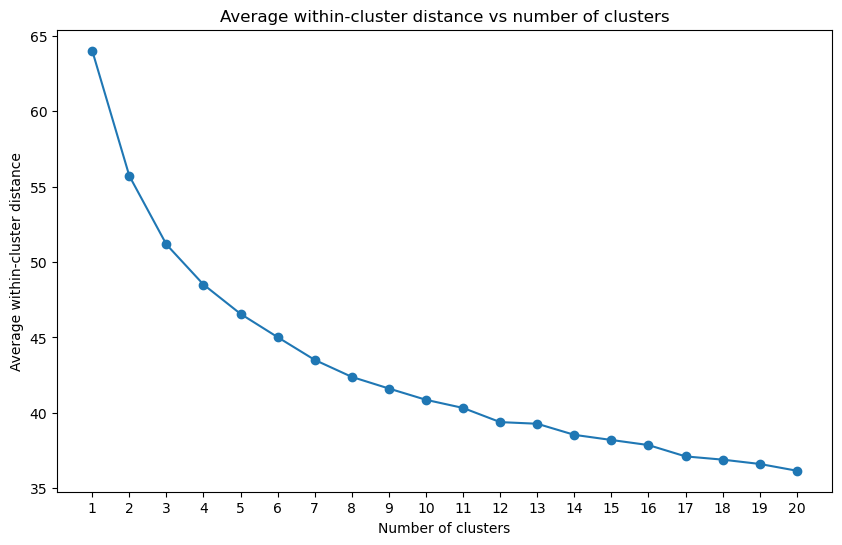

In [83]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10,6))
plt.plot(cluster_counts, avg_dists, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster distance')
plt.title('Average within-cluster distance vs number of clusters')
plt.xticks(np.arange(cluster_counts[0], cluster_counts[-1]+1, step=1))
plt.show()


In [84]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 11, n_init=10, random_state=random_state)
kmeans.fit(pca_transformed_data)
azdias_pred = kmeans.predict(pca_transformed_data)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Answer
opted for 11 clusters as I observed a notable drop in the Average within-cluster distance at k=11, which suggests that further increasing the number of clusters would yield diminishing improvements in clustering quality.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [85]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [86]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean
customers_c = clean_data(customers, cols_to_remove=outliers.index)
display(customers_c.shape)

# Drop misisng data
customers_c_no_md = customers_c.dropna()

# Scale
customers_c_no_md_scaled = pd.DataFrame(scaler.fit_transform(customers_c_no_md),
                                       columns=customers_c_no_md.columns)

# PCA Transform
pca_transformed_cust_data = pca.transform(customers_c_no_md_scaled)

# Predict
customers_pred = kmeans.predict(pca_transformed_cust_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:01<00:00, 47.53it/s]
C:\Users\aljoh\AppData\Local\Temp\ipykernel_2684\201743287.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  azdias_reencoded[col] = azdias_reencoded[col].map(value_map)


(141713, 64)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

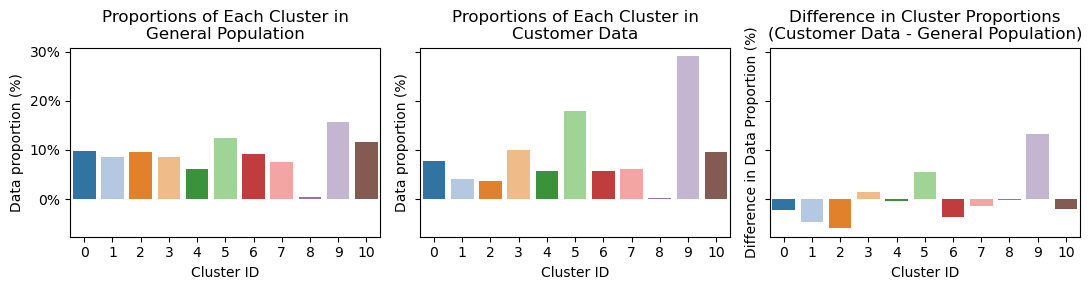

Overrepresented: Cluster 10 (ID=9)
Underrepresented: Cluster 3 (ID=2)


In [87]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
clusters = list(range(azdias_pred.max()+1))

proportions_general = pd.Series(azdias_pred).value_counts(normalize=True)
proportions_customers = pd.Series(customers_pred).value_counts(normalize=True)

# Reindex your series to ensure all clusters are represented and fill any NaN values with 0
proportions_general = proportions_general.reindex(clusters, fill_value=0)
proportions_customers = proportions_customers.reindex(clusters, fill_value=0)

# Calculate the difference
difference = proportions_customers - proportions_general

# Format percentages display
def to_percent(y, position):
    return f'{100 * y:.0f}%'

formatter = FuncFormatter(to_percent)

# Define color palette
palette = sns.color_palette("tab20")[:11]  # Select the first 11 colors

fig, axs = plt.subplots(1, 3, figsize=(11,3), sharey=True)

sns.barplot(x=proportions_general.index, y=proportions_general.values, ax=axs[0], palette=palette)
axs[0].set_xlabel('Cluster ID')
axs[0].set_ylabel('Data proportion (%)')
axs[0].set_title('Proportions of Each Cluster in\nGeneral Population') 
axs[0].yaxis.set_major_formatter(formatter)

sns.barplot(x=proportions_customers.index, y=proportions_customers.values, ax=axs[1], palette=palette)
axs[1].set_xlabel('Cluster ID')
axs[1].set_ylabel('Data proportion (%)')
axs[1].set_title('Proportions of Each Cluster in\nCustomer Data')
axs[1].yaxis.set_major_formatter(formatter)

sns.barplot(x=difference.index, y=difference.values, ax=axs[2], palette=palette)
axs[2].set_xlabel('Cluster ID')
axs[2].set_ylabel('Difference in Data Proportion (%)')
axs[2].set_title('Difference in Cluster Proportions\n(Customer Data - General Population)')
axs[2].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

oc = difference.idxmax()
uc = difference.idxmin()
print(f"Overrepresented: Cluster {oc+1} (ID={oc})")
print(f"Underrepresented: Cluster {uc+1} (ID={uc})")


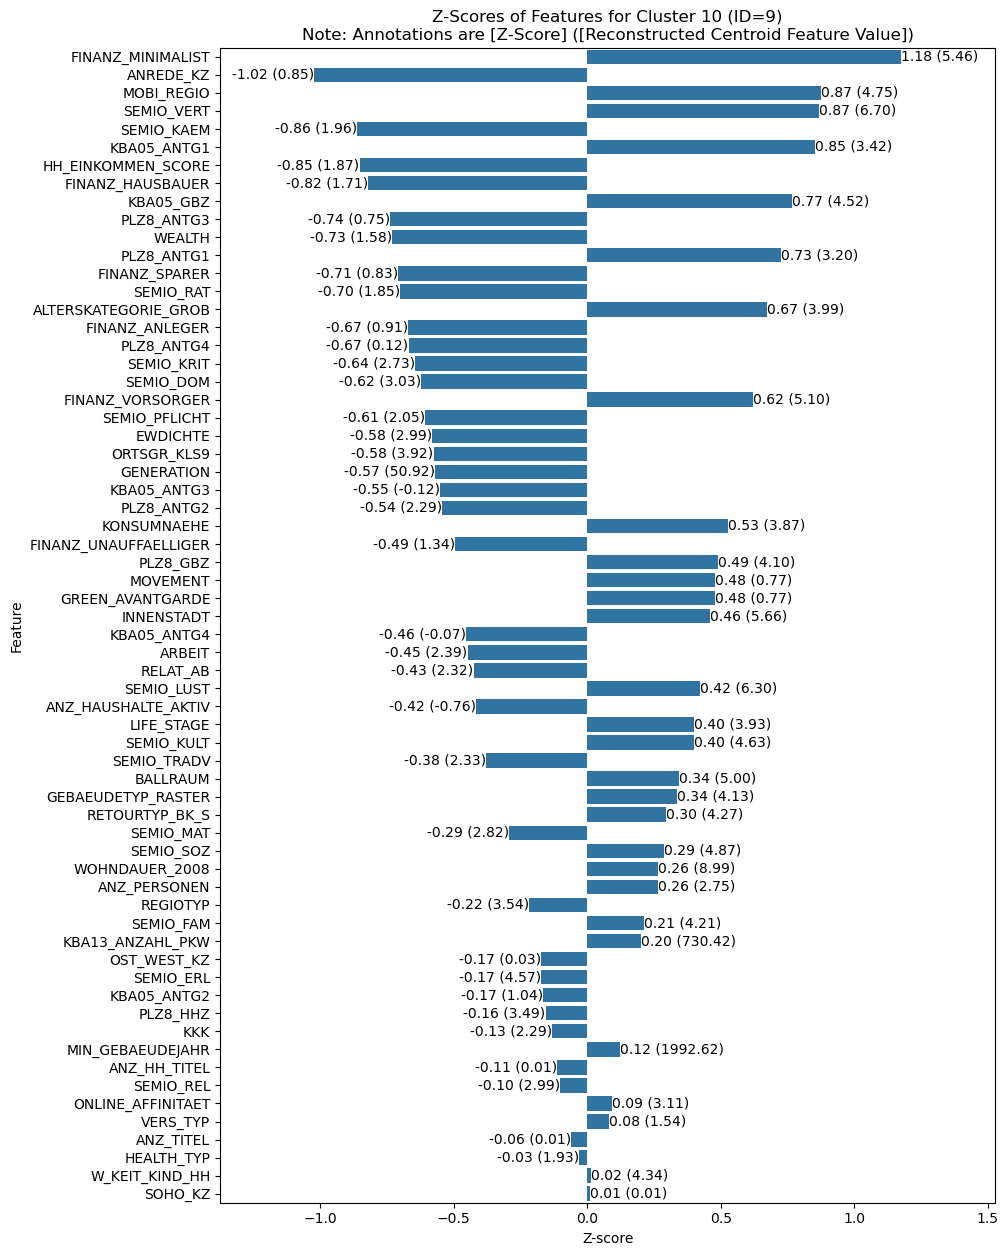

In [88]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster `oc` is overrepresented in the customer data. Let's identify the customers.

def visualize_cluster_features(df, scaler, pca, kmeans, c):
    # Original feature values of the cluster center
    features = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[c].reshape(1, -1))).flatten()

    # Compute the mean and std of each column in the original (scaled) data
    mean = df.mean(axis=0).values
    std = df.std(axis=0).values

    # Compute the z-scores for the cluster center's features
    z_scores = (features - mean) / std
 
    # Create a series for the z-scores
    z_scores_s = pd.Series(data = z_scores, index = df.columns)

    # Convert to Series for easier plotting
    features_s = pd.Series(data = features, index = df.columns)

    # Merge features and z-scores
    features_df = pd.DataFrame({'z-score': z_scores_s, 'value': features_s})

    # Sort by absolute z-score
    features_df = features_df.reindex(features_df['z-score'].abs().sort_values(ascending=False).index)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,15))
    
    # Generate a bar plot
    color = sns.color_palette()[0]
    plot = sns.barplot(y=features_df.index, x=features_df['z-score'], ax=ax, orient='h', color=color)
    
    # Add annotated labels
    for i, p in enumerate(plot.patches):
        width = p.get_width()
        if width < 0:
            plt.text(width, p.get_y() + p.get_height()/2, '{:1.2f} ({:1.2f})'.format(width, features_df['value'][i]), ha = 'right', va = 'center')
        else:
            plt.text(width, p.get_y() + p.get_height()/2, '{:1.2f} ({:1.2f})'.format(width, features_df['value'][i]), ha = 'left', va = 'center')
    
    ax.set_title(f'Z-Scores of Features for Cluster {c+1} (ID={c})\nNote: Annotations are [Z-Score] ([Reconstructed Centroid Feature Value])')
    plt.xlabel("Z-score")
    plt.ylabel("Feature")

    # Find the range of x-values and add/subtract 10% for padding
    xmin, xmax = plot.get_xlim()
    xpadding = (xmax - xmin) * 0.1
    plot.set_xlim(xmin - xpadding, xmax + xpadding)
    
    plt.show()
    return features_df

overrepresented_features = visualize_cluster_features(customers_c_no_md, scaler, pca, kmeans, c=oc)

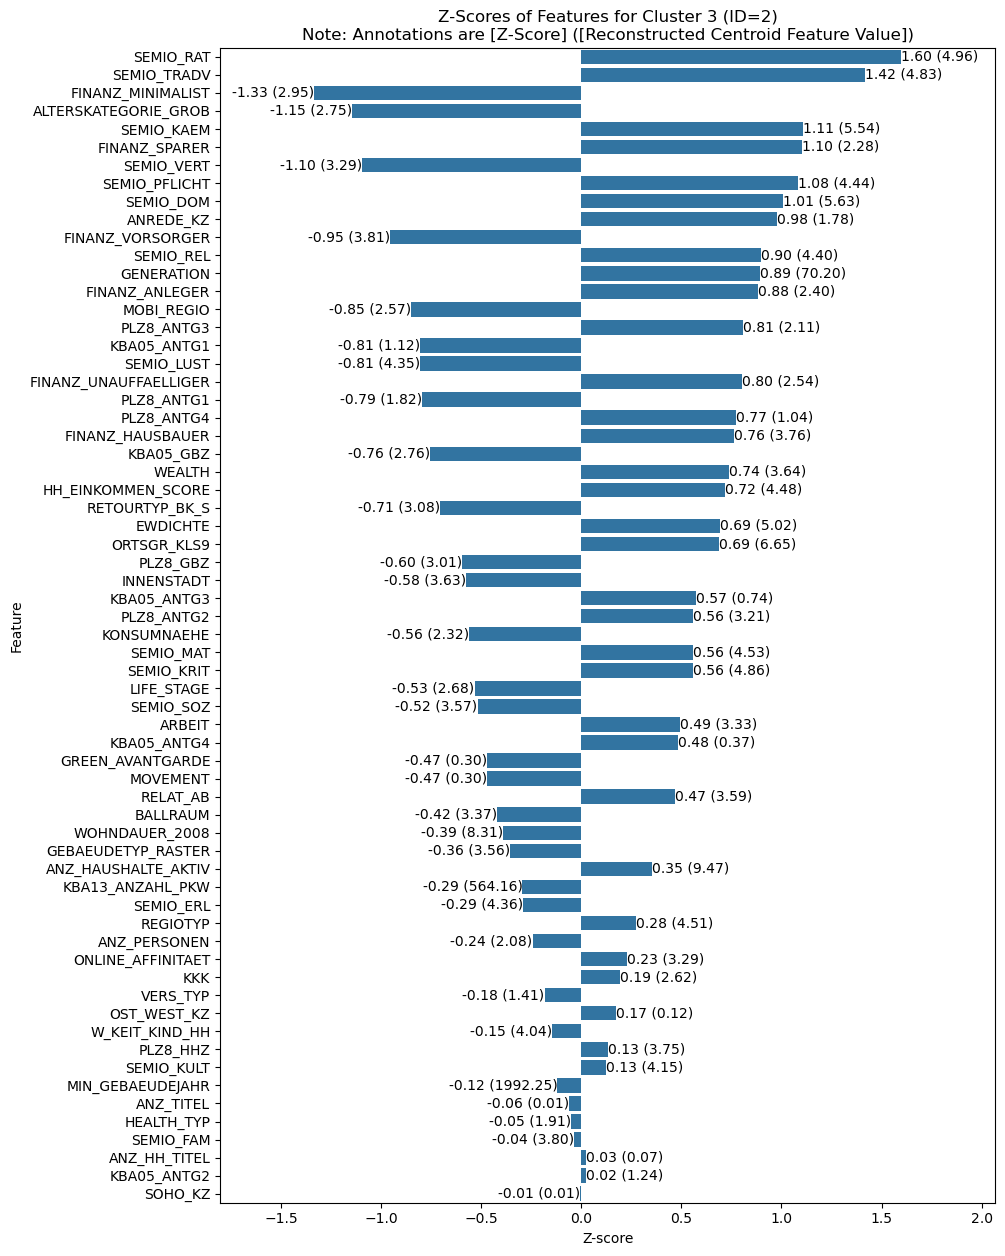

In [89]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_features = visualize_cluster_features(customers_c_no_md, scaler, pca, kmeans, c=uc)


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Answer
Upon comparing the differences in cluster proportions between the general population and the customer population, I identified cluster 10 (ID 9) as having the most significant disparity, implying an overrepresentation of customers within this cluster. Conversely, customers in cluster 3 (ID 2) were found to be underrepresented.

To delve into the characteristics of both overrepresented and underrepresented customers, considering our dataset's 64 features, I took an approach to identify the features that deviate significantly from the norm. This was achieved by ordering the reconstructed centroid features based on their standard deviations from the feature means, known as Z-scores. Let's delve into these characteristics:

Overrepresented Customers:

- High FINANZ_MINIMALIST (z-score 1.18, value 5.46): Customers within this cluster exhibit a markedly low level of financial interest, with a z-score of 1.18 standard deviations above the mean. This suggests a lack of engagement or concern with financial planning or related products.

- Low ANREDE_KZ (z-score -1.02, value 0.85): Predominantly composed of males, this cluster shows a z-score of -1.02 standard deviations below the mean. The feature value of 0.85, closer to 1 (indicating 'male' in the original dataset), corroborates this observation.

- High MOBI_REGIO (z-score 0.87, value 4.75): Customers in this cluster exhibit notably low movement patterns, with a z-score of 0.87 standard deviations above the mean. This could indicate limited geographic mobility or resistance to changing residential areas.

Underrepresented Customers:

- High SEMIO_RAT (z-score 1.6, value 4.96): This cluster displays a propensity for lower rational behavior, with a z-score of 1.6 standard deviations above the mean. This suggests a potential inclination towards decision-making that isn't heavily influenced by logic or facts.

- High SEMIO_TRADV (z-score 1.42, value 4.83): Customers here express diminished affinity for traditional values, reflecting a z-score of 1.42 standard deviations above the mean. This might signify a preference for innovative and modern perspectives.

- Low FINANZ_MINIMALIST (z-score -1.33, value 2.95): This cluster of customers maintains an average financial interest, with a z-score of -1.33 standard deviations below the mean. This suggests a more balanced approach to financial planning or product engagement compared to other clusters.

In this brief summary, I've highlighted key characteristics for both overrepresented and underrepresented customers within specific clusters. While this analysis provides valuable insights, it is important to consider the broader context and perform further analysis to extract comprehensive conclusions.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.